## This notebook contains the code and initial figures of our interrogation of a Gaussian Process Interpolated surface of station usage. 

**The concept of this module of our final project is that we're looking for any advantageous areas of Boston that don't currently have stations that could benefit based on the activity of the stations nearby.**

In [1]:
%matplotlib inline

import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import datetime
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

#set default plot characterstics and colors
from matplotlib import rcParams

import prep_data

dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 8)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15 
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="white"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 1
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

# import findspark
# findspark.init()
# import pyspark
# sc = pyspark.SparkContext(appName="Spark1")

/Users/ta24418/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


**We first load the data into dataframes**

In [2]:
#Load stations df
stations_df = prep_data.stations('https://raw.githubusercontent.com/CS109Hubway/classp/master/data/hubway_stations.csv')
stations_df.head()

id terminal                             station municipal        lat  \
0   3   B32006              Colleges of the Fenway    Boston  42.340021   
1   4   C32000         Tremont St. at Berkeley St.    Boston  42.345392   
2   5   B32012  Northeastern U / North Parking Lot    Boston  42.341814   
3   6   D32000            Cambridge St. at Joy St.    Boston  42.361285   
4   7   A32000                            Fan Pier    Boston  42.353412   

         lng    status  
0 -71.100812  Existing  
1 -71.069616  Existing  
2 -71.090179  Existing  
3 -71.065140  Existing  
4 -71.044624  Existing

In [3]:
# Load trips dataframe
trips_df = prep_data.trips('https://raw.githubusercontent.com/CS109Hubway/classp/master/data/tripsthrough2012.csv')
trips_df.head()

index  seq_id  hubway_id  status  duration          start_date  \
0  140521  140522     157655  Closed       189 2012-03-13 18:31:00   
1  140522  140524     157657  Closed       704 2012-03-15 00:00:00   
2  140523  140523     157656  Closed      1700 2012-03-15 00:00:00   
3  140524  140525     157658  Closed      1411 2012-03-15 00:00:00   
4  140525  140526     157659  Closed       251 2012-03-15 00:03:00   

   strt_statn            end_date  end_statn bike_nr     ...      st_hour  \
0        29.0 2012-03-13 18:34:00       18.0  B00094     ...           18   
1        40.0 2012-03-15 00:12:00       40.0  B00082     ...            0   
2         7.0 2012-03-15 00:28:00       15.0  B00603     ...            0   
3        41.0 2012-03-15 00:24:00       36.0  B00278     ...            0   
4        43.0 2012-03-15 00:07:00       40.0  B00076     ...            0   

  end_hour  st_minute end_minute  st_month  end_month  st_daydate  \
0       18       1111       1114         3          3  2012-03-13   
1        0          0         12         3          3  2012-03-15   
2        0          0         28         3          3  2012-03-15   
3        0          0         24         3          3  2012-03-15   
4        0          3          7         3          3  2012-03-15   

   end_daydate  st_weekday  end_weekday  
0   2012-03-13           1            1  
1   2012-03-15           3            3  
2   2012-03-15           3            3  
3   2012-03-15           3            3  
4   2012-03-15           3            3  

[5 rows x 24 columns]

In [4]:
# Filter dataframe for weekdays and weekends
weekdaystations = trips_df.loc[trips_df.st_weekday < 5]
weekendstations = trips_df.loc[trips_df.st_weekday >= 5]


**Create geodetic grid that we'll interrogate over, this is a bounding box based on present station latitude and longitude.**

In [5]:
# Create interrogation grid
# First need to establish an empty grid that covers all the stations. We'll do this by interrogating the max/min of the station lats/lons
ds = 0.0025
stn_lats = stations_df.lat.tolist()
stn_lons = stations_df.lng.tolist()
lat_ex = [np.min(stn_lats),np.max(stn_lats)]
lon_ex = [np.min(stn_lons),np.max(stn_lons)]
lats_lin = np.arange(lat_ex[0]-ds,lat_ex[1]+(2*ds),step=ds)
lons_lin = np.arange(lon_ex[0]-ds,lon_ex[1]+(2*ds),step=ds)
LATS,LONS = np.meshgrid(lats_lin,lons_lin,indexing='xy')

lats = LATS.reshape((-1,1))
lons = LONS.reshape((-1,1))

# Create arrays of interrogation grid locations (corresponding to array to be plugged into ESS)
X = np.concatenate((lons,lats),axis=1)
stns_gd = np.concatenate((np.array(stn_lons).reshape((-1,1)),np.array(stn_lats).reshape((-1,1))),axis=1)
X = np.concatenate((X,stns_gd),axis=0)

# Create empty arrays for intensity values, will populate the last 140ish entries from trips_df
stn_rentals_weekday = np.zeros((X.shape[0],len(np.unique(trips_df.st_hour))))
stn_returns_weekday = np.zeros((X.shape[0],len(np.unique(trips_df.st_hour))))

stn_rentals_weekend = np.zeros((X.shape[0],len(np.unique(trips_df.st_hour))))
stn_returns_weekend = np.zeros((X.shape[0],len(np.unique(trips_df.st_hour))))

**Helper functions**

* Gather hour-by-hour of station usage

* Implement ESS

In [6]:
def get_station_usage(weekday, hour):
    '''Helper function that pulls the data from each station at a given hour 
    and returns the net usage of each station in the system (rentals/returns)~(+/-)
    ------------------------------- INPUTS ---------------------------------------
    weekday: trips dataframe that is filtered based on being a weekday or weekend
    hour:    the specified hour over which we want to aggregate data
    ------------------------------- OUTPUT ---------------------------------------
    usage:   the net usage for each station in the system. If there is no information
             for any station in the given hour, a zero is returned.'''
    
    # Create array of zeros corresponding to each station
    rentals = np.zeros(len(stations_df.station))
    returns = np.zeros(len(stations_df.station))
    
    #filter dataframe for specified hour,compute the trips in and out, and store numbers of in and out trips lists
    weekday_hr =  weekday.loc[weekday.st_hour == hour ]
    grouped_rentals = weekday_hr.groupby('strt_statn',as_index=False)['seq_id'].count().values
    grouped_returns = weekday_hr.groupby('end_statn',as_index=False)['seq_id'].count().values
    
    # Associate each station with the correct index
    for ii in range(len(grouped_rentals)):
        rent_id, rent_val = int(grouped_rentals[ii,0])-3, grouped_rentals[ii,1]
        rentals[rent_id] += rent_val

    for jj in range(len(grouped_returns)):
        retu_id, retu_val = int(grouped_returns[jj,0])-3, grouped_returns[jj,1]
        returns[retu_id] += retu_val
    
    return rentals, returns

In [7]:
# Elliptical Slice Sampler (Murray, Adams, and MacKay JMLR 2010)
# Inputs:
# Y: observed data
# Sig: covariance matrix of the prior
# log_lik: the log likelihood function
# N_mcmc: number of desired samples
# burn_in: number of burn in iterations
# N: dimensionality of the input, this should be M+1 because alpha is part of Sigma

# returns an array of samples of size N_mcmc x N
def ess(Y, Sig,log_lik, N_mcmc, burn_in, N):
#     print 'running elliptical slice sampling...'
    mcmc_samples = np.zeros((N_mcmc+burn_in, N))
    norm_samples = np.random.multivariate_normal(np.zeros(N), Sig, N_mcmc+burn_in)
    unif_samples = np.random.uniform(0,1,N_mcmc+burn_in)
    theta = np.random.uniform(0,2*np.pi,N_mcmc+burn_in)
    theta_min = theta-2*np.pi
    theta_max = theta+2*np.pi
    for i in range(1,N_mcmc+burn_in):
        f = mcmc_samples[i-1,:]
        llh_thresh = log_lik(f,Y) + np.log(unif_samples[i])
        f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i])
        while log_lik(f_star,Y) < llh_thresh:
            if theta[i] < 0:
                theta_min[i] = theta[i]
            else:
                theta_max[i] = theta[i]
            theta[i] = np.random.uniform(theta_min[i],theta_max[i],1)  
            f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i]) 
        mcmc_samples[i,:] = f_star
    return mcmc_samples[(burn_in+1):(burn_in+N_mcmc),]

**Create arrays of intensity values**

In [8]:
# Populate the intensity arrays (hour by hour)
for hr in xrange(len(np.unique(trips_df.st_hour))):

    weekday_rentals, weekday_returns = get_station_usage(weekdaystations,hr)
    
    stn_rentals_weekday[-len(weekday_rentals):,hr] = weekday_rentals
    stn_returns_weekday[-len(weekday_returns):,hr] = weekday_returns
    
    weekend_rentals, weekend_returns = get_station_usage(weekendstations,hr)
    
    stn_rentals_weekend[-len(weekend_rentals):,hr] = weekend_rentals
    stn_returns_weekend[-len(weekend_returns):,hr] = weekend_returns

**Create arrays for the interpolated output**

In [9]:
interp_rentals_weekday = np.empty_like(stn_rentals_weekday)
interp_returns_weekday = np.empty_like(stn_returns_weekday)
interp_rentals_weekend = np.empty_like(stn_rentals_weekend)
interp_returns_weekend = np.empty_like(stn_rentals_weekend)

**Calculate the effect of station proximity on the inference over the interrogation grid (covariance)**

In [10]:
# Calculate the covariance between grid cells according to squared exponential kernel
phi = 0.00003 # Length scale, adjusts
M = X.shape[0]
Sigma = np.zeros((M,M))
for ii in xrange(M):
    Sigma[ii,:] = np.exp(-1.*(1./phi)*np.linalg.norm(X-X[ii],axis=1)**2)

# Augment covariance to include independent alpha parameter
new_sigma = np.eye(M+1)
new_sigma[1:,1:] = Sigma
# Matrix is not PSD so we augment the diagonal just slightly
new_sigma += 0.05*np.eye(M+1)

**Set up parameter arrays, log-likelihood, etc. for surface interpolation**

**We model the arrival of riders as a weighted Poisson process in the same manner as we did in HW 4, problem 1**

In [11]:
# Sample from MVN to get alpha and Z_i, then calculate the lambda_i
params = scipy.stats.multivariate_normal.rvs(np.zeros(M+1),new_sigma)
lmda = np.exp(params[0]+params[1:])
wlmda = ds*ds * lmda
def log_lhood(params,observed):
    # Create lambda from parameters (fronted by w^2)
    lmda = ds*ds * np.exp(params[0]+params[1:])
    # Calculate the log-likelihood via the logpmf functions from the Poisson distribution
    log_lik = np.sum(scipy.stats.poisson.logpmf(observed,lmda))
    return log_lik

In [12]:
N_mcmc = 5000
burn_in = 500
N = M+1
# Loop through each hour, for all weekend/weekday and rental/return data
for hr in xrange(stn_rentals_weekday.shape[1]):
    
    rentals_weekday = stn_rentals_weekday[:,hr]
    returns_weekday = stn_returns_weekday[:,hr]
    
    rentals_weekend = stn_rentals_weekend[:,hr]
    returns_weekend = stn_returns_weekend[:,hr]
    

    out_rentals_weekday = ess(rentals_weekday, new_sigma, log_lhood, N_mcmc, burn_in, N)
    out_returns_weekday = ess(returns_weekday, new_sigma, log_lhood, N_mcmc, burn_in, N)
        
    out_rentals_weekend = ess(rentals_weekend, new_sigma, log_lhood, N_mcmc, burn_in, N)
    out_returns_weekend = ess(returns_weekend, new_sigma, log_lhood, N_mcmc, burn_in, N)

    post_alphas1 = out_rentals_weekday[:,0].reshape((out_rentals_weekday.shape[0],1))
    post_zs1 = out_rentals_weekday[:,1:]
    post_lambdas1 = np.exp(post_alphas1+post_zs1)
    post_lambda_1 = np.mean(post_lambdas1,axis=0)
    
    post_alphas2 = out_returns_weekday[:,0].reshape((out_returns_weekday.shape[0],1))
    post_zs2 = out_returns_weekday[:,1:]
    post_lambdas2 = np.exp(post_alphas2+post_zs2)
    post_lambda_2 = np.mean(post_lambdas2,axis=0)

    post_alphas3 = out_rentals_weekend[:,0].reshape((out_rentals_weekend.shape[0],1))
    post_zs3 = out_rentals_weekend[:,1:]
    post_lambdas3 = np.exp(post_alphas3+post_zs3)
    post_lambda_3 = np.mean(post_lambdas3,axis=0)

    post_alphas4 = out_returns_weekend[:,0].reshape((out_returns_weekend.shape[0],1))
    post_zs4 = out_returns_weekend[:,1:]
    post_lambdas4 = np.exp(post_alphas4+post_zs4)
    post_lambda_4 = np.mean(post_lambdas4,axis=0)
    
    interp_rentals_weekday[:,hr] = post_lambda_1
    interp_returns_weekday[:,hr] = post_lambda_2
    interp_rentals_weekend[:,hr] = post_lambda_3
    interp_returns_weekend[:,hr] = post_lambda_4
print "Finished interpolating over all instances of recorded data"

Finished interpolating over all instances of recorded data


**Plot interpolation for weekdays**

/Users/ta24418/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


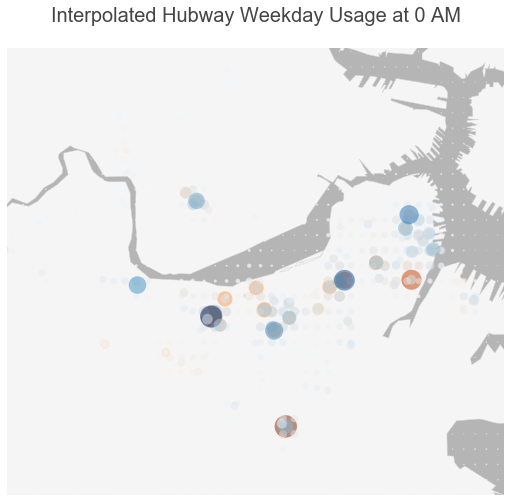

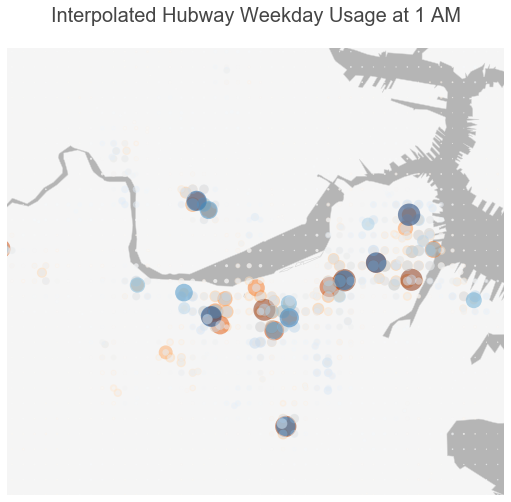

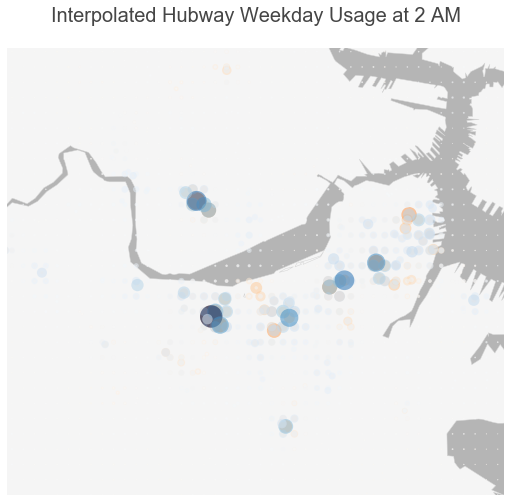

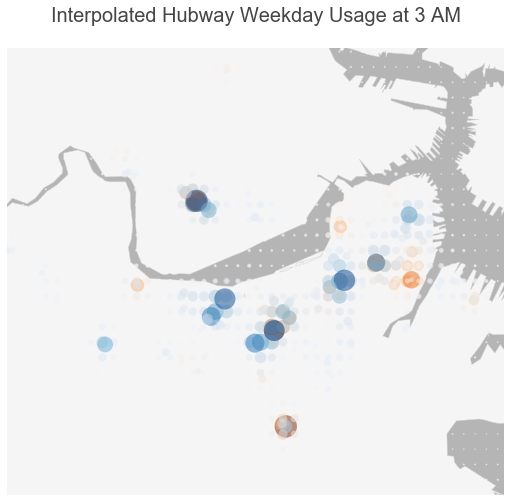

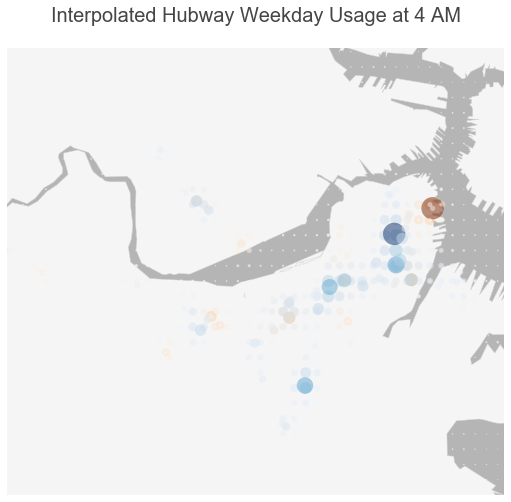

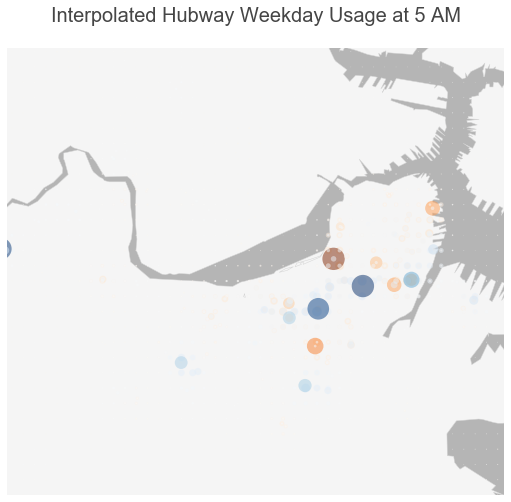

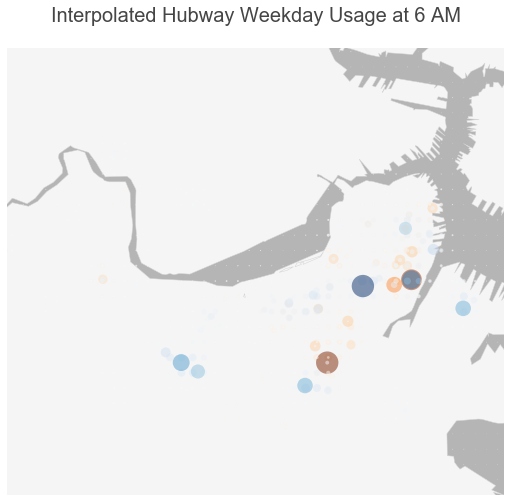

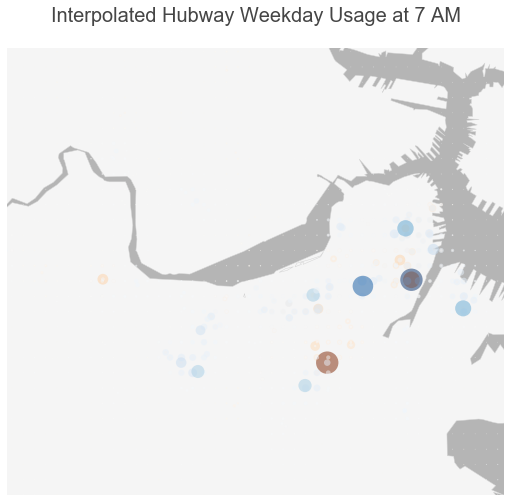

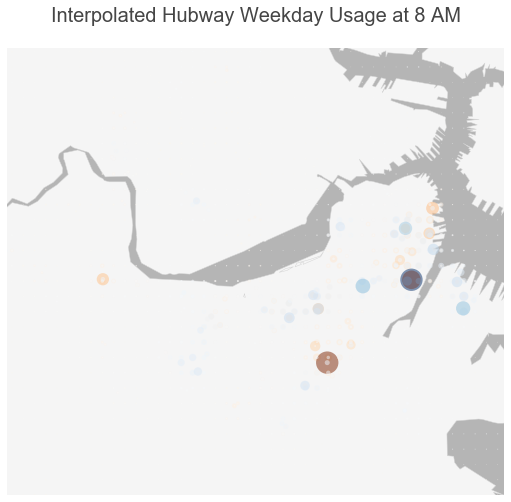

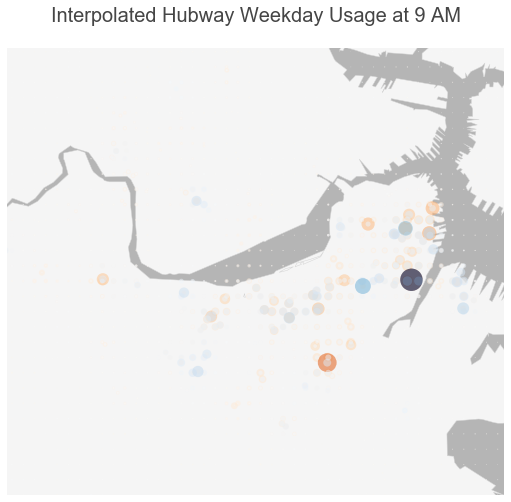

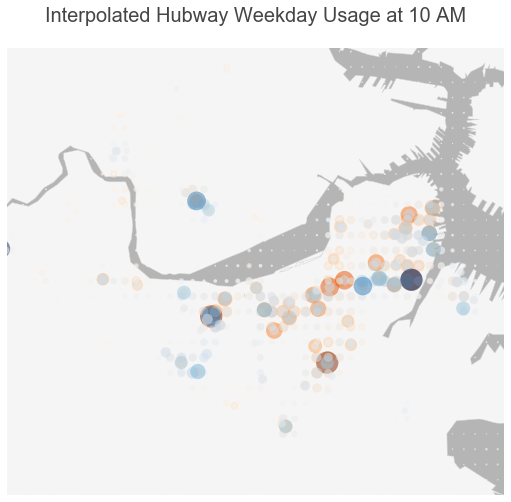

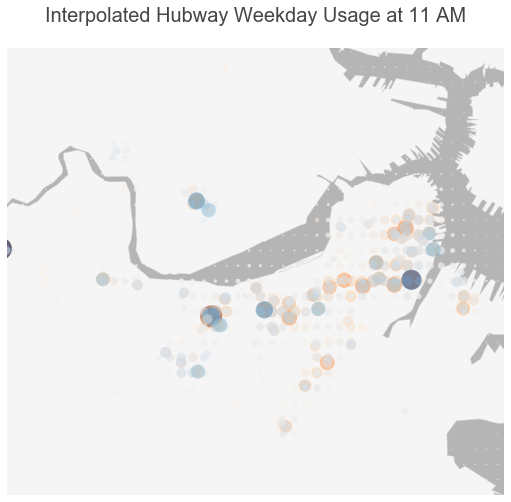

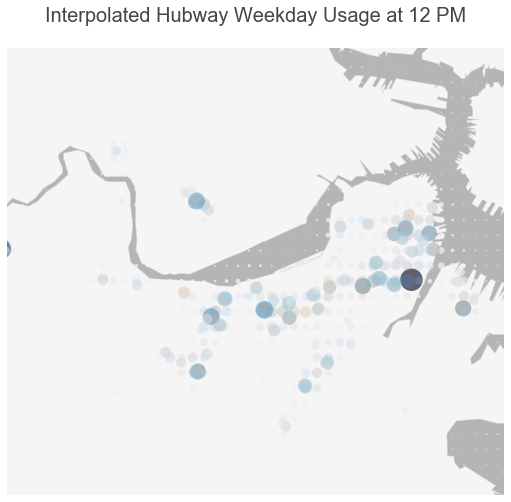

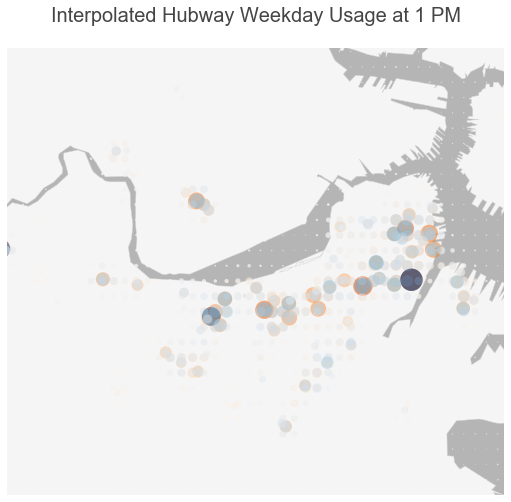

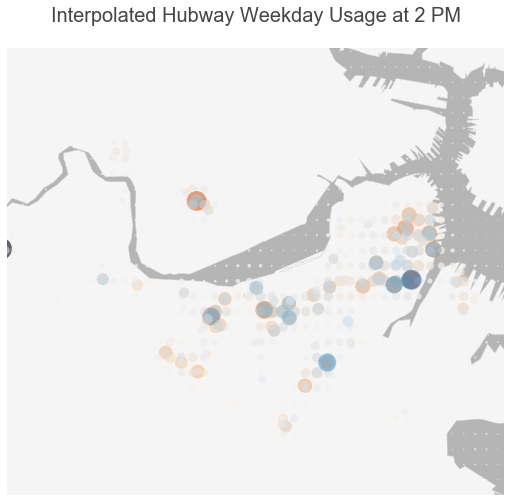

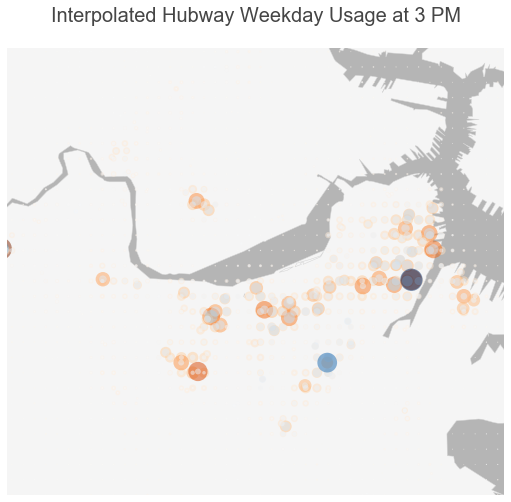

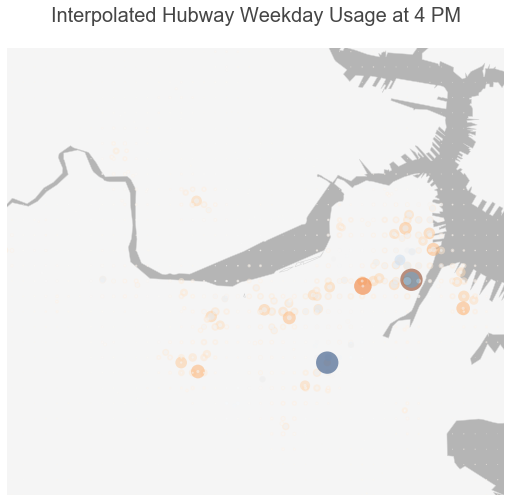

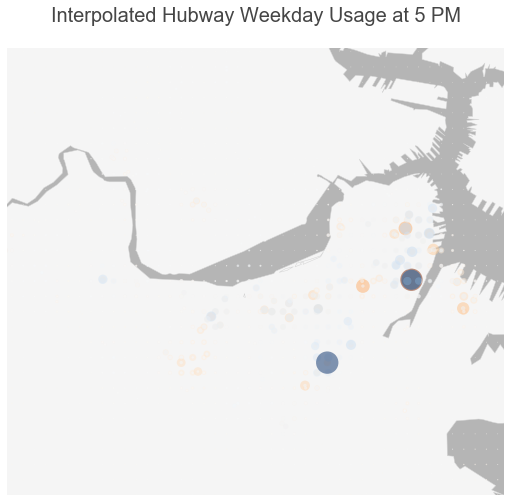

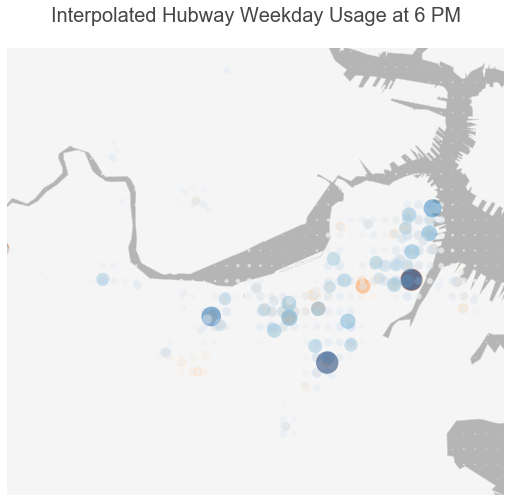

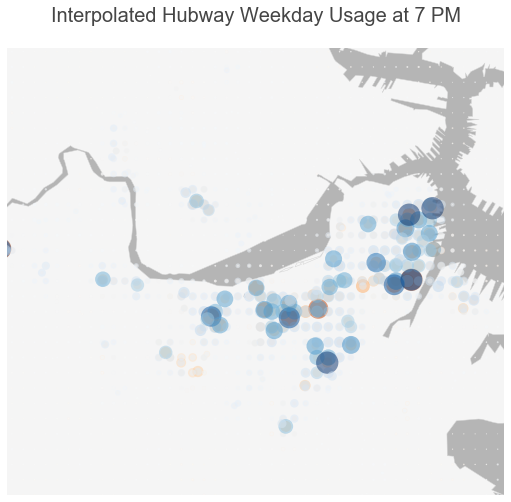

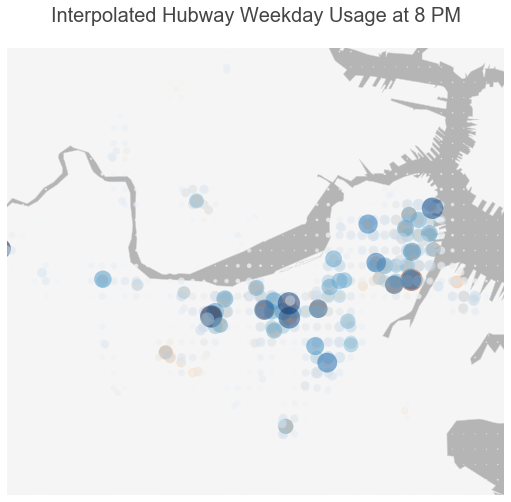

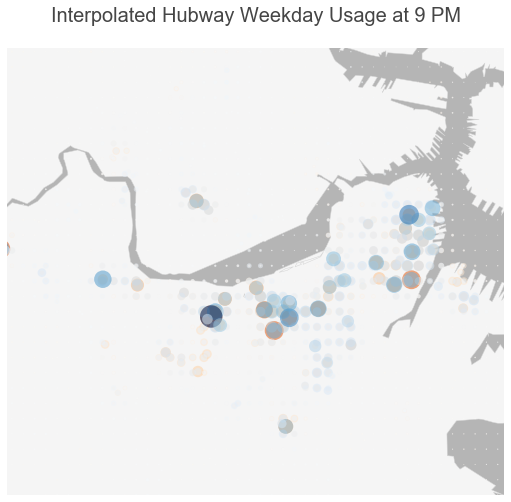

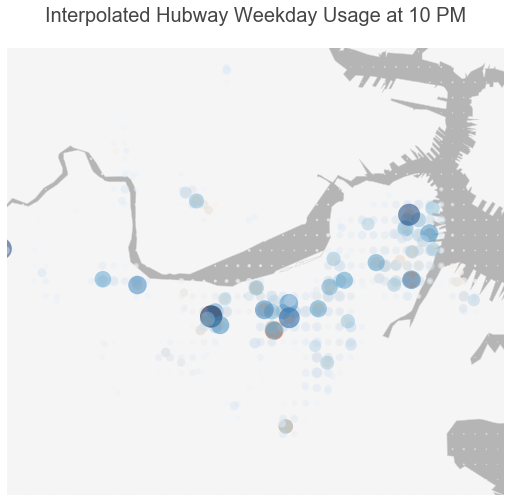

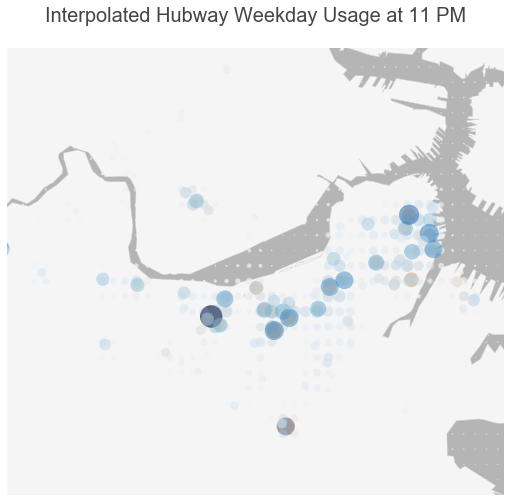

In [13]:
for hour in xrange(interp_rentals_weekday.shape[1]):
    
    time_title = str(hour)+" AM" if hour < 12 else str(hour)+" PM" if hour == 12 else str(hour%12)+" PM"
    img_num = str(hour+1)
    while len(img_num)<3:
        img_num = "0"+img_num
    
    temp_rentals = interp_rentals_weekday[:,hour]
    temp_returns = interp_returns_weekday[:,hour]
    
    scaled_rentals = [t*1.0/(np.max(temp_rentals)*1.0)*500.0 for t in temp_rentals]
    scaled_returns = [t*1.0/(np.max(temp_returns)*1.0)*500.0 for t in temp_returns]

    #set up plot with mercator projection and coastline for context
    plt.figure()
    m=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.317, urcrnrlon=-71.035, urcrnrlat=42.39, resolution='c')
    m.drawmapboundary(fill_color='#F5F5F5',  linewidth=0)
    m.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5')
    poly = Polygon(m.waterlyr[0], facecolor='#B5B5B5')
    plt.gca().add_patch(poly)

    # compute the native map projection coordinates for stations 
    xout,yout = m(X[:,0],X[:,1])
    colors_rentals = [t*1.0/(np.max(temp_rentals)*1.0) for t in temp_rentals]
    colors_returns = [t*1.0/(np.max(temp_returns)*1.0) for t in temp_returns]
    
    #plot trip departures using scaled circles at the station locations 
    m.scatter( xout, yout,  c=colors_rentals, cmap='Oranges', s=scaled_rentals, marker='o', alpha=0.5,zorder = 2, vmin=0, )
    m.scatter( xout, yout,  c=colors_returns, cmap='Blues', s=scaled_returns, marker='o', alpha=0.5,zorder = 2, vmin=0, )
    plt.title('Interpolated Hubway Weekday Usage at ' + time_title + '\n')
    
    plt.savefig('interpolated_weekday/figure' + img_num)

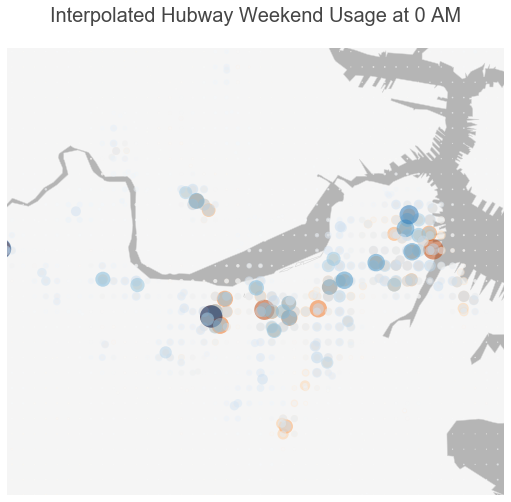

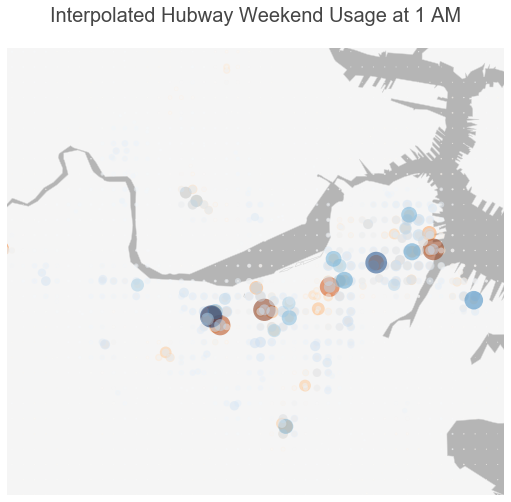

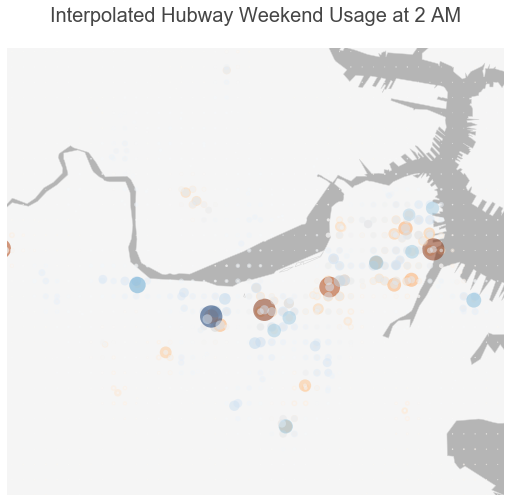

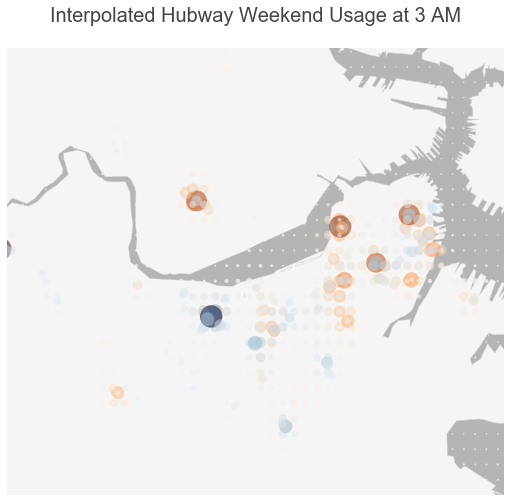

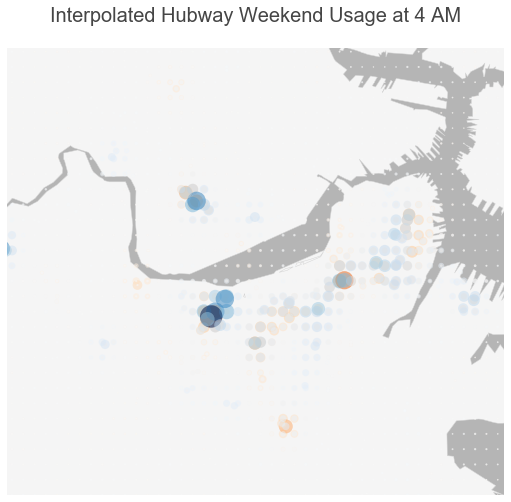

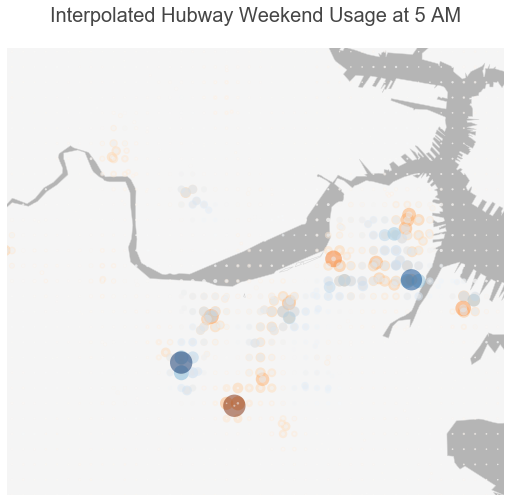

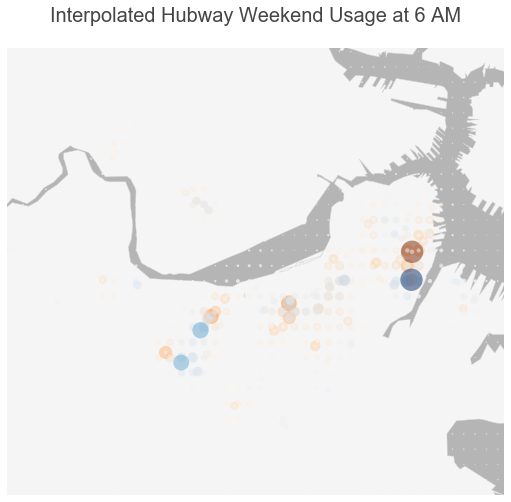

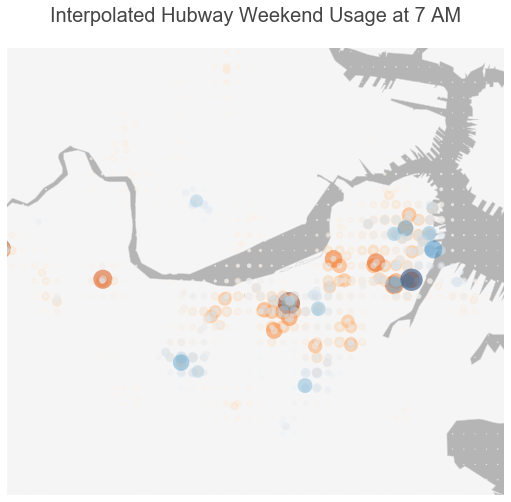

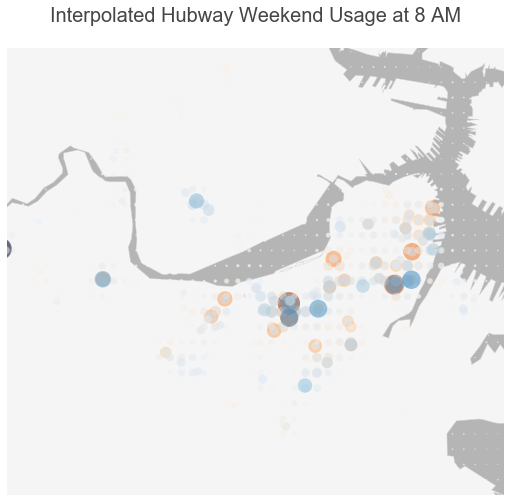

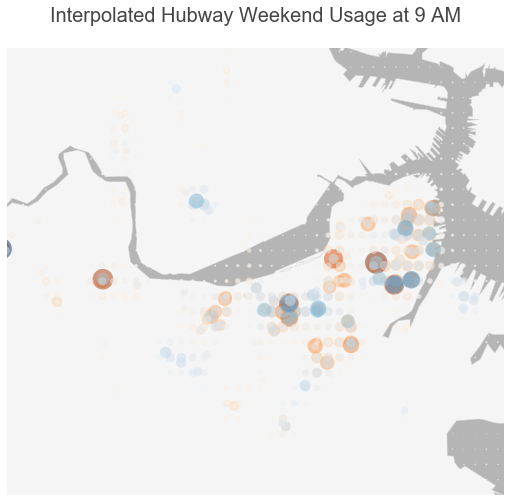

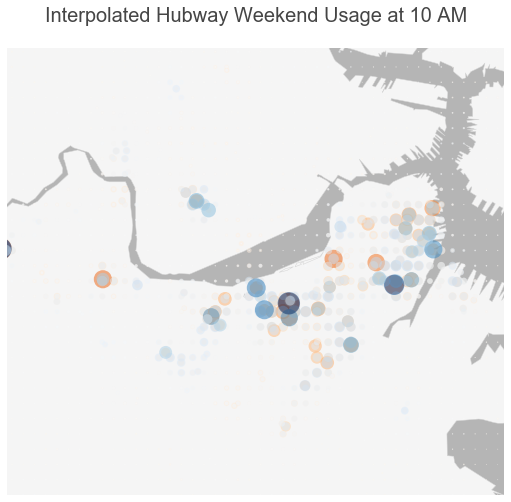

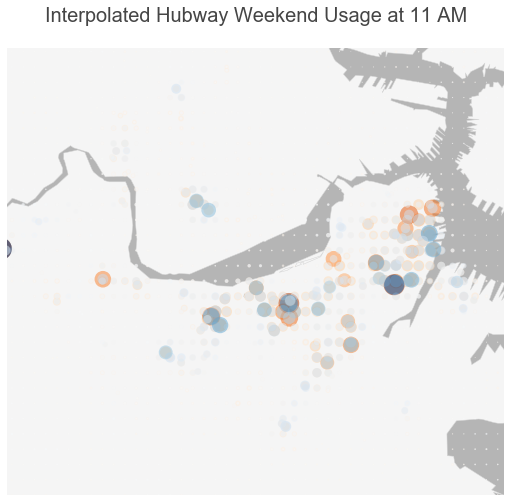

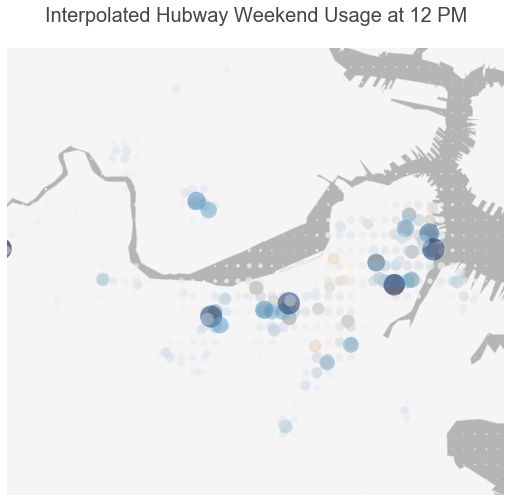

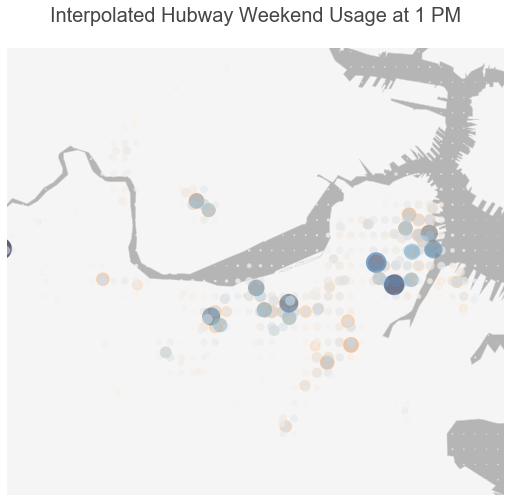

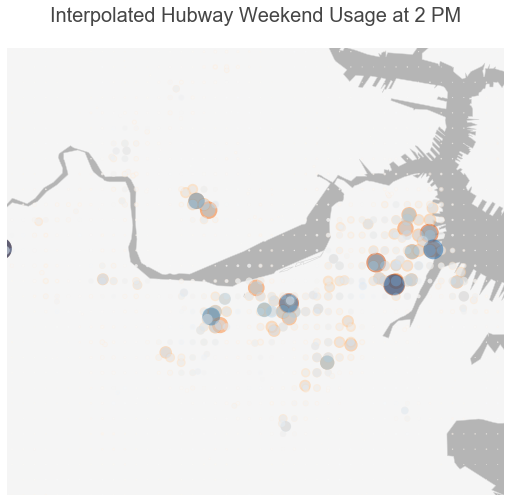

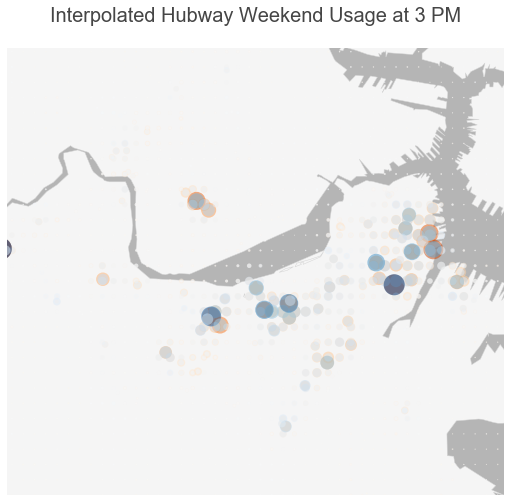

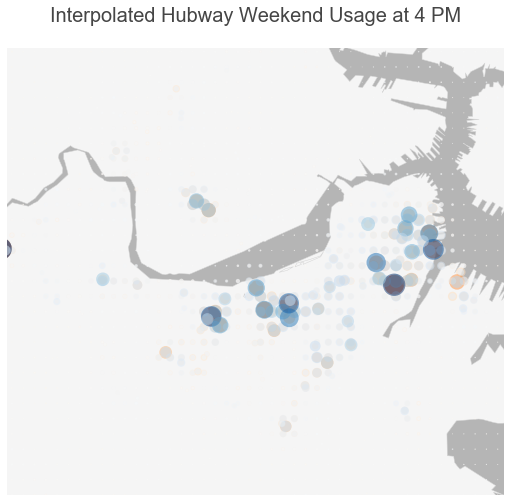

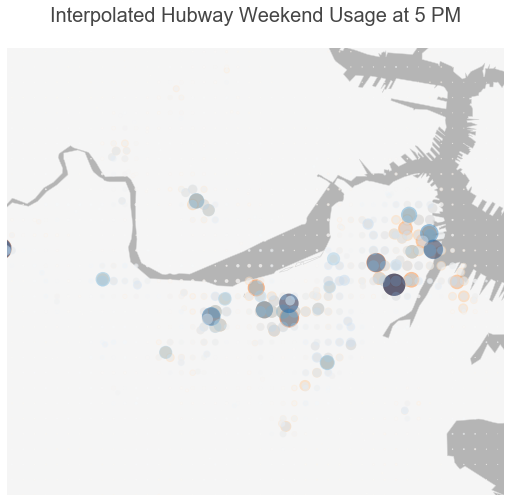

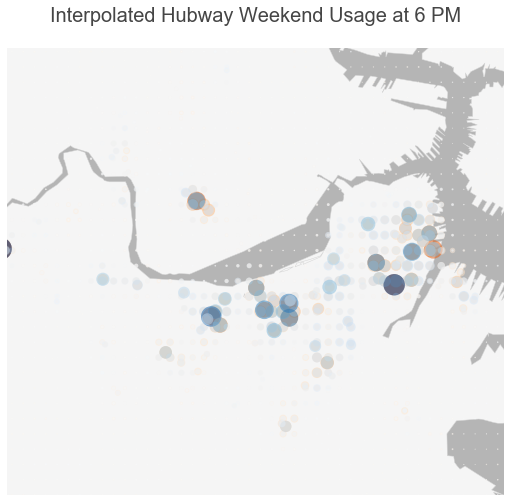

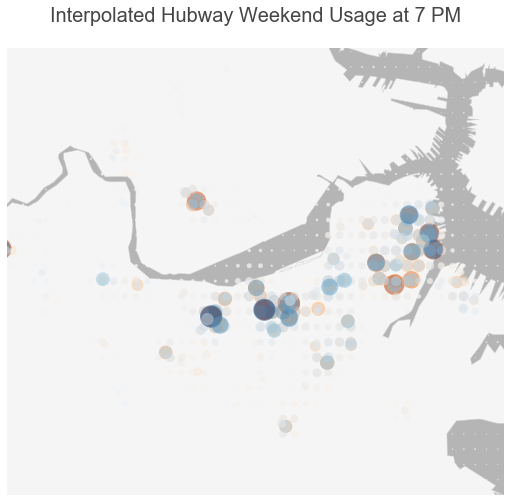

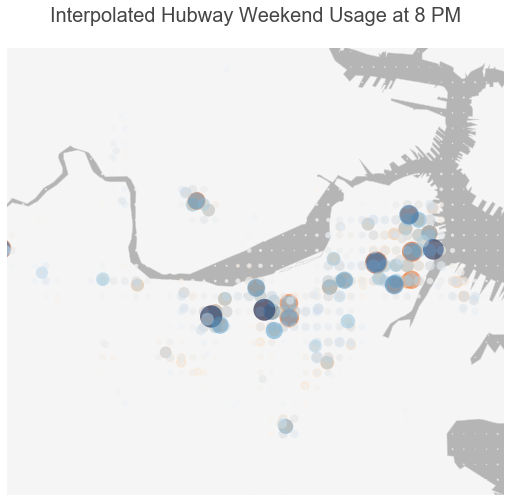

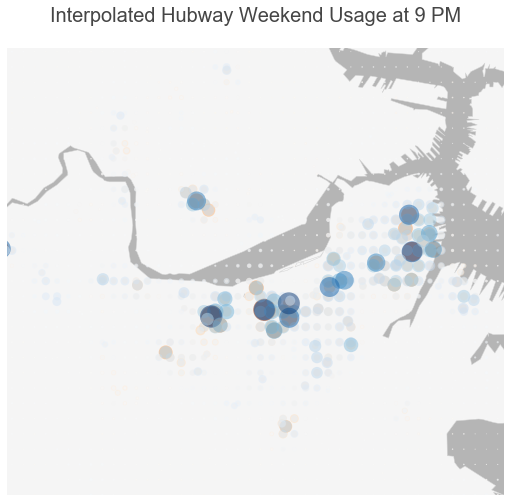

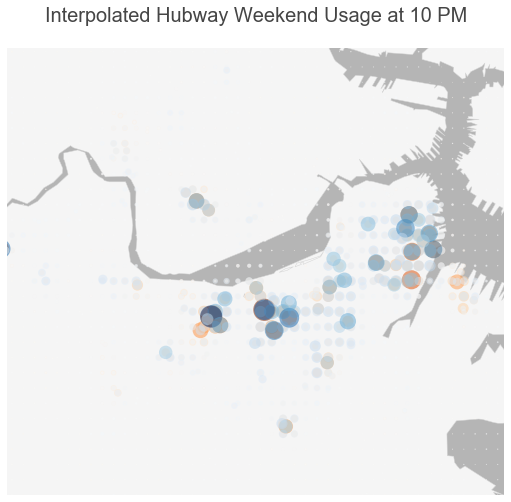

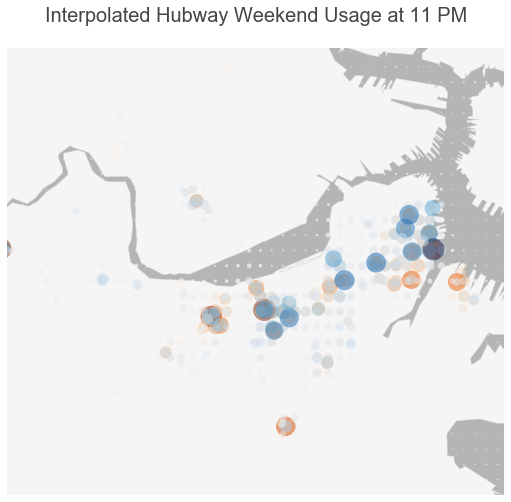

In [14]:
for hour in xrange(interp_rentals_weekend.shape[1]):
    
    time_title = str(hour)+" AM" if hour < 12 else str(hour)+" PM" if hour == 12 else str(hour%12)+" PM"
    img_num = str(hour+1)
    while len(img_num)<3:
        img_num = "0"+img_num
    
    temp_rentals = interp_rentals_weekend[:,hour]
    temp_returns = interp_returns_weekend[:,hour]
    
    scaled_rentals = [t*1.0/(np.max(temp_rentals)*1.0)*500.0 for t in temp_rentals]
    scaled_returns = [t*1.0/(np.max(temp_returns)*1.0)*500.0 for t in temp_returns]

    #set up plot with mercator projection and coastline for context
    plt.figure()
    m=Basemap(projection='merc',llcrnrlon=-71.145, llcrnrlat=42.317, urcrnrlon=-71.035, urcrnrlat=42.39, resolution='c')
    m.drawmapboundary(fill_color='#F5F5F5',  linewidth=0)
    m.readshapefile('data/water_shp/water_shp', 'waterlyr', drawbounds=True,color='#D5D5D5')
    poly = Polygon(m.waterlyr[0], facecolor='#B5B5B5')
    plt.gca().add_patch(poly)

    # compute the native map projection coordinates for stations 
    xout,yout = m(X[:,0],X[:,1])
    colors_rentals = [t*1.0/(np.max(temp_rentals)*1.0) for t in temp_rentals]
    colors_returns = [t*1.0/(np.max(temp_returns)*1.0) for t in temp_returns]
    
    #plot trip departures using scaled circles at the station locations 
    m.scatter( xout, yout,  c=colors_rentals, cmap='Oranges', s=scaled_rentals, marker='o', alpha=0.5,zorder = 2, vmin=0, label="Rentals")
    m.scatter( xout, yout,  c=colors_returns, cmap='Blues', s=scaled_returns, marker='o', alpha=0.5,zorder = 2, vmin=0, label="Returns")
    plt.title('Interpolated Hubway Weekend Usage at ' + time_title + '\n')
    
    plt.savefig('interpolated_weekend/figure' + img_num)